# Numerical Methods

# Lecture 7: Numerical Linear Algebra III

## Learning objectives:

* Introduce ill-conditioned matrices (via matrix norms and the condition number)


* Consider direct vs indirect (or iterative) methods


* Example iterative algorithm: the *Jacobi* and *Gauss-Seidel* methods


* A pointer to more advanced algorithms (supplementary readings)


In [99]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import scipy.linalg as sl

## Ill-conditioned matrices

The conditioning (or lack of, i.e. the ill-conditioning) of matrices we are trying to invert - to obtain the inverse, or to find the solution to a corresponding linear matrix system - is incredibly important for the success of any algorithm.

When we started talking about matrices we noted that as long as the matrix is non-singular, i.e. $\det(A)\ne 0$, then an inverse exists, and a linear system with that $A$ has a unique solution.

But what happens when we consider a matrix that is *nearly* singular, i.e. $\det(A)$ is very small?

Well smallness is a relative term and so we need to ask the question of how large or small $\det(A)$ is compared to something.

That something is the *norm* of the matrix.


#### Vector norms

For a vector $\boldsymbol{v}$ (assumed to be an $n\times 1$ column vector) we have multiple possible norms to help us decide quantify the magnitude or size of that vector:

\begin{align}
\|\boldsymbol{v}\|_2 & = \sqrt{v_1^2 + v_2^2 + \cdots + v_n^2} = \left(\sum_{i=1}^n v_i^2 \right)^{1/2}, &\quad{\textrm{termed the two-norm or Euclidean norm}}\\
\|\boldsymbol{v}\|_1  & = |v_1| + |v_2| + \cdots + |v_n| = \sum_{i=1}^n |v_i|, &\quad{\textrm{termed the one-norm or taxi-cab norm}}\\
\|\boldsymbol{v}\|_{\infty}  &= \max\{|v_1|,|v_2|, \ldots, |v_n|\} = \max_{i=1}^n |v_i|, &\quad{\textrm{termed the max-norm or infinity norm}}
\end{align}


#### Matrix norms

We can define similar measures for the size of matrices, e.g. for $A$ which for complete generality we will assume is of shape $m\times n$:

\begin{align}
\|A\|_F & = \left(\sum_{i=1}^m \sum_{j=1}^n A_{ij}^2 \right)^{1/2}, &\quad{\textrm{termed the matrix Euclidean or Frobenius norm}}\\
\|A\|_{\infty} & = \max_{i=1}^m \sum_{j=1}^n|A_{i,j}|, &\quad{\textrm{termed the maximum absolute row-sum norm}}\\
\end{align}

Note that while these norms give different results (in both the vector and matrix cases), they are consistent or equivalent in that they are always within a constant factor of one another (a result that is true for finite-dimensional or discrete problems as we are considering here). 

This means we don't really need to worry too much about which norm we're using, as long as we are comparing vectors or matrices of the same size.

[NB. if $n$ or $m$ changes for example and we want to fairly compare two vectors or matrices, then in the vector case the so-called *RMS* error would in many cases be a more suitable choice than the two-norm.]

Let's evaluate some examples.

In [100]:
A = np.array([[10., 2., 1.],[6., 5., 4.],[1., 4., 7.]])
print(A)

[[10.  2.  1.]
 [ 6.  5.  4.]
 [ 1.  4.  7.]]


In [101]:
print(sl.norm(A))

15.748015748023622


In [102]:
# the "Frobenius" (or Euclidean) norm from above 
print(sl.norm(A,'fro'))
# clearly the default for sl.norm as it returns the same answer as not specifying the norm
print(sl.norm(A,'fro') == sl.norm(A))

15.748015748023622
True


In [103]:
# the maximum absolute row-sum
print(sl.norm(A,np.inf))

15.0


In [104]:
# the maximum absolute column-sum
print(sl.norm(A,1))

17.0


In [105]:
# the two-norm - note that this is NOT the same as the Frobenius norm
# as might be expected by comparing the terminology for the vector and matrix norms
# the matrix two-norm is also termed the spectral norm
print(sl.norm(A,2))

13.793091098640064


In [106]:
# which is defined as (!!!!)
print(np.sqrt(np.real((np.max(sl.eigvals( A.T @ A))))))
# i.e. involves the eigenvalues of the matrix A.T@A, 
# or the so-called "singular values" of A - see module on Geophysical Inversion

13.793091098640064


### <span style="color:blue">Exercise 7.1: matrix norms</span>

Write some code to explicitly compute the two matrix norms defined mathematically above (i.e. the Frobenius and the maximum absolute row-sum norms) and compare against the values found above using in-built scipy functions.

Also, based on the above code and comments, what is the mathematical definition of the 1-norm and the 2-norm?


### Matrix conditioning

The (ill-)conditioning of a matrix is measured with the matrix condition number:

$$\textrm{cond}(A) = \|A\|\|A^{-1}\|$$

If this is close to one then $A$ is termed *well-conditioned*; the value increases with the degree of *ill-conditioning*, reaching infinity for a singular matrix.

Let's evaluate the condition number for the matrix above.

In [107]:
A = np.array([[10., 2., 1.],[6., 5., 4.],[1., 4., 7.]])

print(A)
print(np.linalg.cond(A))  # let's use the in-built condition number function
print(sl.norm(A,2)*sl.norm(sl.inv(A),2))  # so the default condition number uses the matrix two-norm
print(np.linalg.cond(A,'fro')) # this is how to use a different norm
print(sl.norm(A,'fro')*sl.norm(sl.inv(A),'fro'))

[[10.  2.  1.]
 [ 6.  5.  4.]
 [ 1.  4.  7.]]
10.713371881346792
10.713371881346786
12.463616561943589
12.463616561943587


The condition number is expensive to compute, and so in practice the relative size of the determinant of the matrix can be gauged based on the magnitude of the entries of the matrix.

#### Example

We know that a singular matrix does not result in a unique solution to its corresponding linear matrix system. But what are the consequences of near-singularity (ill-conditioning)?

Consider the following example


$$
\left(
  \begin{array}{cc}
    2 & 1 \\
    2 & 1 + \epsilon  \\
  \end{array}
\right)\left(
  \begin{array}{c}
    x \\
    y \\
  \end{array}
\right) = \left(
  \begin{array}{c}
    3 \\
    0 \\
  \end{array}
\right)
$$

Clearly when $\epsilon=0$ the two columns/rows are not linear independent, and hence the determinant of this matrix is zero, the condition number is infinite, and the linear system does not have a solution (as the two equations would be telling us the contradictory information that $2x+y$ is equal to 3 and is also equal to 0).

### <span style="color:blue">Exercise 7.2: Ill-conditioned matrix</span>

For the example above, consider a range of small values for $\epsilon$ and calculate the matrix determinant and condition number.

You should find for $\epsilon=0.001$ that $\det(A)=0.002$ (i.e. quite a lot smaller than the other coefficients in the matrix) and $\textrm{cond}(A)\approx 5000$.

Using `sl.inv(A) @ b` you should also be able to compute the solution $\boldsymbol{x}=(1501.5,-3000.)^T$.

What happens when you make a very small change to the coefficients of the matrix (e.g. set $\epsilon=0.002$)?

You should find that this change of just $0.1\%$ in one of the coefficients of the matrix (i.e. $1.001$ becoming $1.002$) results in a $100\%$ change in both components of the solution!

This is the consequence of the matrix being *ill-conditioned* - we should be careful about trusting the numerical solution to ill-conditioned problems.

A way to see this is to recognise that computers do not perform arithmetic exactly - they necessarily have to [truncate numbers](http://www.mathwords.com/t/truncating_a_number.htm) at a certain number of significant figures, performing multiple operations with these truncated numbers can lead to an erosion of accuracy. Often this is not a problem, but these so-called [roundoff](http://mathworld.wolfram.com/RoundoffError.html) errors in algorithms generating $A$, or operating on $A$ as in Gaussian elimination etc, will lead to small inaccuracies in the coefficients of the matrix. Hence, in the case of ill-conditioned problems, will fall foul of the issue seen above where a very small error in an input to the algorithm led to a far larger error in an output.

### Roundoff errors

Note that in this course we have largely ignored the limitations of the floating point arithmetic performed by computers, including round-off errors.  

This is often the topic of the first lecture of courses, or first chapter of books, on Numerical Methods or Numerical Analysis - do take a look at some examples if you are interested.  

Also take a look at *D. Goldberg 1991: What every computer scientist should know about floating-point arithmetic, ACM Computing Surveys 23, Pages 5-48*.

For some examples of catastrophic failures due to round off errors see <https://www.ma.utexas.edu/users/arbogast/misc/disasters.html> and <http://ta.twi.tudelft.nl/users/vuik/wi211/disasters.html> and [the sinking of the Sleipner A offshore platform](http://www.ima.umn.edu/~arnold/disasters/sleipner.html).

<br>

As an example, consider the mathematical formula

$$f(x)=(1-x)^{10}.$$

We can of course relatively easily expand this out by hand

$$f(x)=1- 10x + 45x^2 - 120x^3 + 210x^4 - 252x^5 + 210x^6 - 120x^7 + 45x^8 - 10x^9 + x^{10}.$$

Mathematically these two expressions for $f(x)$ are identical; when evaluated by a computer different operations will be performed, which (we hope) should give the same answer. For numbers $x$ away from $1$ these two expressions do return (pretty much) the same answer.  

However, for $x$ close to 1 the second expression adds and subtracts individual terms of increasing size which should largely cancel out, but they don't to sufficient accuracy due to round off errors; these errors accumulate with more and more operations, leading a loss of significance <https://en.wikipedia.org/wiki/Loss_of_significance>

In [108]:
def f1(x):
    return (1. - x)**10

def f2(x):
    return (1. - 10.*x + 45.*x**2 - 120.*x**3 +
           210.*x**4 - 252.*x**5 + 210.*x**6 -
           120.*x**7 + 45.*x**8 - 10.*x**9 + x**10)

# for a value of x away from 1
x=0.6
print(f1(x), f2(x), 1.-f1(x)/f2(x), '\n') # print values computed in different ways and their relative difference
# the error is far down the significant figures

# things get a bit worse as x gets closer to 1
x=0.8
print(f1(x), f2(x), 1.-f1(x)/f2(x), '\n') 

# and a significant error (21%) can be see for a number close to 1
x=0.95
print(f1(x), f2(x), 1.-f1(x)/f2(x)) 
# f2 is simply swamped with round off errors

0.00010485760000000006 0.00010485760000436464 4.1623815505431594e-11 

1.0239999999999978e-07 1.0240001356576212e-07 1.3247813024364063e-07 

9.765625000000086e-14 1.2378986724570495e-13 0.21111273343425307


### Algorithm stability

The susceptibility for a numerical algorithm to dampen (inevitable) errors, rather than to magnify them as we have seen in examples above, is termed *stability*.  This is a concern for numerical linear algebra as considered here, as well as for the numerical solution of differential equations.  In that case you don't want small errors to grow and accumulate as you propagate the solution to an ODE or PDE forward in time say.

If your algorithm is not inherently stable, or has other limitation, you need to understand and appreciate this, as it can cause catastrophic failures! 


## Direct vs indirect/iterative methods

Two types/families of methods exist to solve matrix systems.  These are termed *direct* methods and *iterative* (or *indirect*) methods.

Direct methods perform operations on the linear equations (the matrix system), e.g. the substitution of one equation into another which we performed two weeks ago for your example $2\times 2$ system considered in MM1. This (and the subsequent Gaussian elimination algorithm) transformed the equations making up the linear system into equivalent ones with the aim of eliminating unknowns from some of the equations and hence allowing for easy solution through back (or forward) substitution.

Also, in MM1 you (may have) learnt *Cramer's rule* which gives an explicit formula for the inverse of a matrix, or for the solution of a linear matrix system.  

The computational cost (in terms of arithmetic operations required; also termed complexity) of Cramer's rule scales like $(n+1)!$, whereas the Gaussian elimination method (which is basically the substitution method descrined above, and implemented over the previous two lectures) scales like $n^3$.  $n$ here refers to the number of unknowns or equations, or sometimes termed the *degrees of freedom* of the problem.

For large $n$ Gaussian elimination will clearly be far more efficient. 

<br>

An advantage of direct methods such as Cramer's rule or Gaussian elimination is that they provide the exact solution (assuming exact arithmetic, i.e. ignoring the round off related issues mentioned above) in a finite number of operations, the number of which are known in advance.

However, as pointed out previously, $n$ could be billions for hard-core applications such as in numerical weather forecasting. In this case the $n^3$ operations required of a direct algorithm such as Gaussian elimination is completely prohibitive. In an attempt to further reduce this cost *iterative/indirect* algorithms were devised.



Iterative or indirect algorithms start with an initial guess at the solution ($\boldsymbol{x}_0$), and *iteratively* improve this producing a series of approximate answers $\boldsymbol{x}_k$. 

For the *exact* answer to the matrix system 

$$A\boldsymbol{x} = \boldsymbol{b}$$ 

we know that the residual vector 

$$\boldsymbol{r} := A\boldsymbol{x}-\boldsymbol{b}$$ 

is zero. 

For our iterative procedure, we can use the norm of the residual vector 

$$\boldsymbol{r}_k := A\boldsymbol{x}_k-\boldsymbol{b}$$ 

based on the approximate solution $\boldsymbol{x}_k$, as a measure of how close we are to solving the equation (the norm $\|\boldsymbol{r}_k\|$ expresses this as a single number). 

As we iterate further, we hope to drive down this number and we may stop the iterations at some small (non-zero) residual norm tolerance level - we never expect to hit a residual of zero exactly. 

The final iteration gives us an answer $\boldsymbol{x}_k$ which is still an approximation to the solution and not the exact (subject to round off errors!) solution we would obtain with direct methods.  The residual norm tolerance stopping criteria therefore needs to be thought about carefully, e.g. depending on how accurate a solution $\boldsymbol{x}$ we require.

We have already considered Gaussian elimination (and back substitution) as examples of direct solution methods. We'll consider an example of an iterative method now.

## Iterative methods - Jacobi's method

Consider our matrix system

$$A\boldsymbol{x}=\boldsymbol{b} \quad \iff \quad \sum_{j=1}^nA_{ij}x_j=b_i,\quad \textrm{for}\quad i=1,2,\ldots, n.$$

Let's rewrite this by pulling out the term involving $x_i$ (i.e. for each row $i$ pull out the diagonal from the summation):

$$A_{ii}x_i + \sum_{\substack{j=1\\ j\ne i}}^nA_{ij}x_j=b_i,\quad  i=1,2,\ldots, n.$$

We can then rearrange to come up with a formula for our unknown $x_i$:

$$x_i = \frac{1}{A_{ii}}\left(b_i- \sum_{\substack{j=1\\ j\ne i}}^nA_{ij}x_j\right),\quad  i=1,2,\ldots, n.$$

<br><br>

Now of course for each individual $x_i$, all the other components of $\boldsymbol{x}$ appearing on the RHS are also unknown and so this is an example of an implicit formula which doesn't help us directly, but does suggest the following iterative scheme:


* Starting from a guess at the solution $\boldsymbol{x}^{(0)}$



* iterate for $k>0$
$$x_i^{(k)} = \frac{1}{A_{ii}}\left(b_i- \sum_{\substack{j=1\\ j\ne i}}^nA_{ij}x_j^{(k-1)}\right),\quad  i=1,2,\ldots, n.$$


Note that for this iteration, for a fixed $k$, it does not matter in which order we perform the operations over $i$ as the right hand side only contains the entries of $\boldsymbol{x}$ at the previous iteration [based on this system can you think of a possible way to improve this algorithm?]

Let's implement and test this algorithm:

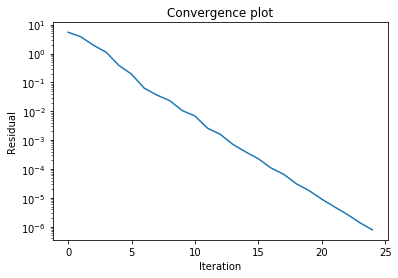

Total number of iterations:  24
[-0.16340811 -0.01532703  0.27335262  0.36893551]
[-0.16340816 -0.01532706  0.27335264  0.36893555]


In [109]:
A = np.array([[10., 2., 3., 5.],
                [1., 14., 6., 2.],
                [-1., 4., 16., -4],
                [5. ,4. ,3. ,11. ]])
b = np.array([1., 2., 3., 4.])

# an initial guess at the solution - here just a vector of zeros of length the number of rows in A
x = np.zeros(A.shape[0]) 

# specify an iteration tolerance - our stopping criteria
tol = 1.e-6 

# specify an upper limit on the number of iterations - if we don't hit tolerance
# then stop the algorithm, so that it doesn't go on forever potentially
it_max = 1000

# for later plotting let's start a list to store the residuals
residuals=[] 

# now iterate
for it in range(it_max):
    x_new = np.zeros(A.shape[0])  # initialise the new solution vector
    for i in range(A.shape[0]):
        x_new[i] = (1./A[i, i]) * (b[i] 
                                   - (np.dot(A[i, :i], x[:i]) 
                                   + np.dot(A[i, i+1:], x[i+1:])))

        "np.dot(A[i, :i], x[:i]) calculates dot product of row i column 0 up to i-1 and x up to i-1"
        " = sum from LHS of diagonal row i"
        " ... "
        " this excludes diagonal from summation for each row"
        "only considers X in PREVIOUS iteration --> requires storing (x)"

    residual = sl.norm(A @ x - b)  # calculate the norm of the residual r=Ax-b for this latest guess
    residuals.append(residual) # store it for later plotting
    if (residual < tol): # if less than our required tolerance jump out of the iteration and end.
        break

    x = x_new # update old solution

# plot the log of the residual against iteration number 
fig = plt.figure(figsize=(6, 4))
ax1 = plt.subplot(111)
ax1.semilogy(residuals) # plot the log of the residual against iteration number
" semilog plot (log on y-axis and linear on x-axis"
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Residual')
ax1.set_title('Convergence plot')
plt.show()

# print out the number of iterations, 
# if this is it_max we know the algorithm didn't actually converge
print('Total number of iterations: ', it)

print(x_new) # our solution vector
print(sl.inv(A) @ b)  # check against scipy

## Iterative methods - Gauss-Seidel's method

We can make a small improvement to Jacobi's method using the updated components of the solution vector as soon as they become available (rather than only using them in the following iteration):


* Starting from a guess at the solution $\boldsymbol{x}^{(0)}$



* iterate for $k>0$
$$x_i^{(k)} = \frac{1}{A_{ii}}\left(b_i- \sum_{\substack{j=1\\ j< i}}^nA_{ij}x_j^{(k)} - \sum_{\substack{j=1\\ j> i}}^nA_{ij}x_j^{(k-1)}\right),\quad  i=1,2,\ldots, n.$$


Note that as opposed to Jacobi, we can overwrite the entries of $\boldsymbol{x}$ as they are updated, with Jacobi we need to store both the new as well as the old iteration (i.e. not overwrite the old entries until we have finished with them - which was not until the end of every iteration).

As we are using updated knowledge immediately, the Gauss-Seidel algorithm we hope that we should converge faster than Jacobi 

[but note that this convergence can only be *guaranteed* for matrices which are diagonally dominant - that is for every row, the magnitude of value on the main diagonal is greater than the sum of the magnitudes of all the other entries in that row - or if the matrix is *symmetric positive definite* (a property we won't define in this module].  



### <span style="color:blue">Exercise 7.3: Implement Gauss-Seidel's method.</span>

Generalise the Jacobi code to solve the matrix problem using Gauss-Seidel's method.